In [5]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.models as models


NameError: name '_C' is not defined

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dir_buenas, dir_rayadas, transformacion=None):
        self.dir_buenas = dir_buenas
        self.dir_rayadas = dir_rayadas
        self.transformacion = transformacion

        # Asumimos que cada imagen 'buena' tiene su correspondiente imagen 'rayada' con el mismo nombre
        self.nombres_archivos = os.listdir(dir_buenas)

    def __len__(self):
        return len(self.nombres_archivos)

    def __getitem__(self, idx):
        ruta_img_buena = os.path.join(self.dir_buenas, self.nombres_archivos[idx])
        ruta_img_rayada = os.path.join(self.dir_rayadas, self.nombres_archivos[idx])

        img_buena = Image.open(ruta_img_buena).convert('L')  # Convertir a escala de grises
        img_rayada = Image.open(ruta_img_rayada).convert('L')

        if self.transformacion:
            img_buena = self.transformacion(img_buena)
            img_rayada = self.transformacion(img_rayada)

        return img_rayada, img_buena    


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

In [9]:
class Generador(nn.Module):
    def __init__(self, n_residual_blocks=16, ruta_pesos = None, tam_kernel=4):
        super(Generador, self).__init__()

        # Encoder: Capas de convolución para reducir la dimensión
        self.hidden_enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=tam_kernel, stride=2, padding=1),  # 500x500 -> 250x250
            nn.LeakyReLU(0.01, inplace=True)
        )
        self.hidden_enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=tam_kernel, stride=2, padding=1),  # 250x250 -> 125x125
            nn.LeakyReLU(0.01, inplace=True)
        )
        self.hidden_enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=tam_kernel, stride=2, padding=1),  # 125x125 -> 63x63
            nn.LeakyReLU(0.01, inplace=True)
        )

        # Bloques residuales en el 'cuello de botella'
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(128) for _ in range(n_residual_blocks)]
        )

        # Decoder: Capas transpuestas de convolución para aumentar la dimensión
        self.hidden_dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=tam_kernel, stride=2, padding=1, output_padding=1),  # 63x63 -> 128x128
            nn.LeakyReLU(0.01, inplace=True)
        )
        self.hidden_dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=tam_kernel, stride=2, padding=1, output_padding=1),  # 128x128 -> 256x256
            nn.LeakyReLU(0.01, inplace=True)
        )
        self.hidden_dec3 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=tam_kernel, stride=2, padding=1, output_padding=1),  # 256x256 -> 512x512
            nn.Tanh()
        )
        
        if ruta_pesos is not None:
            self.cargar_pesos(ruta_pesos)
            
    
    def cargar_pesos(self, ruta_peso):
        # Cargar los pesos guardados
        self.load_state_dict(torch.load(ruta_peso, map_location=lambda storage, loc: storage))
        print(f'Pesos cargados desde: {ruta_peso}')
    

    def forward(self, x):
        # Encoder
        x = self.hidden_enc1(x)
        x = self.hidden_enc2(x)
        x = self.hidden_enc3(x)

        # Bloques residuales
        x = self.res_blocks(x)

        # Decoder
        x = self.hidden_dec1(x)
        x = self.hidden_dec2(x)
        x = self.hidden_dec3(x)

        # Redimensionamiento para garantizar las dimensiones correctas de la salida
        x = F.interpolate(x, size=(500, 500), mode='bilinear', align_corners=False)

        return x

In [10]:
def visualizar_imagenes(imagen_buena, imagen_generada):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(imagen_buena[0].cpu().squeeze(0), cmap='gray')
    plt.title('Imagen Buena')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(imagen_generada[0].cpu().squeeze(0), cmap='gray')
    plt.title('Imagen Generada')
    plt.axis('off')

    plt.show()

In [11]:
def guardar_modelo(modelo, ruta, epoch):
    # Crear directorio si no existe
    directorio = os.path.dirname(ruta)
    if not os.path.exists(directorio):
        os.makedirs(directorio)

    # Ruta del archivo con información de la época
    ruta_completa = f'{ruta}_epoch_{epoch}.pth'
    torch.save(modelo.state_dict(), ruta_completa)
    print(f'Modelo guardado en: {ruta_completa}')
    

In [12]:
class PerceptualLoss(nn.Module):
    def __init__(self, device):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:23]
        self.device = device
        self.vgg_submodel = vgg.to(device)  # Asegúrate de mover VGG al dispositivo adecuado
        for param in self.vgg_submodel.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        # Asegúrate de que la entrada y el objetivo estén en el mismo dispositivo
        input = input.to(self.device)
        target = target.to(self.device)
        # Replicar los canales si es necesario
        if input.shape[1] == 1:
            input = input.repeat(1, 3, 1, 1)
        if target.shape[1] == 1:
            target = target.repeat(1, 3, 1, 1)
        perception_loss = F.mse_loss(self.vgg_submodel(input), self.vgg_submodel(target))
        return perception_loss

In [13]:

class CombinedLoss(nn.Module):
    def __init__(self, lambda_mse=0.8, lambda_perceptual=1.0, device=None):
        super(CombinedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.perceptual_loss = PerceptualLoss(device)
        self.lambda_mse = lambda_mse
        self.lambda_perceptual = lambda_perceptual

    def forward(self, output, target):
        loss_mse = self.mse_loss(output, target)
        loss_perceptual = self.perceptual_loss(output, target)
        return self.lambda_mse * loss_mse + self.lambda_perceptual * loss_perceptual
    

In [14]:
def preentrenar_generador(device,modelo_generador, conjunto_datos, dispositivo, num_epochs=100, learning_rate=0.001, intervalo_visualizacion=10, intervalo_guardado=10, ruta_guardado="/home/rodrigo/Documentos/5to semestre/machin/modelos/"):
    # Criterio y optimizador
    criterio = CombinedLoss(lambda_mse=1.0, lambda_perceptual=0.01, device=device)

    optimizador = optim.Adam(modelo_generador.parameters(), lr=learning_rate)
    
    # Cargador de datos
    cargador_datos = DataLoader(conjunto_datos, batch_size=16, shuffle=True)

    # Ciclo de entrenamiento
    modelo_generador.train()
    for epoch in range(num_epochs):
        perdida_total = 0

        for data in cargador_datos:
            # Solo necesitamos las imágenes buenas porque estamos replicándolas
            _, imagenes_buenas = data
            imagenes_buenas = imagenes_buenas.to(dispositivo)

            # Forward pass
            outputs = modelo_generador(imagenes_buenas)
            perdida = criterio(outputs, imagenes_buenas)

            # Backward y optimización
            optimizador.zero_grad()
            perdida.backward()
            optimizador.step()

            perdida_total += perdida.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Pérdida: {perdida_total/len(cargador_datos)}')
        
        # Guardar el modelo cada 'intervalo_guardado' épocas
        if (epoch + 1) % intervalo_guardado == 0:
            guardar_modelo(modelo_generador, ruta_guardado, epoch+1)

        # Visualización de las imágenes
        if (epoch + 1) % intervalo_visualizacion == 0:
            with torch.no_grad():
                # Seleccionar una imagen aleatoria del conjunto de datos
                _, imagen_buena = next(iter(cargador_datos))
                imagen_buena = imagen_buena.to(dispositivo)
                imagen_generada = modelo_generador(imagen_buena)

                visualizar_imagenes(imagen_buena, imagen_generada)

    return modelo_generador

cuda


/home/rodrigo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rodrigo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/160], Pérdida: 0.17259497454632883
Epoch [2/160], Pérdida: 0.07598262215438097
Epoch [3/160], Pérdida: 0.06555563130456468
Epoch [4/160], Pérdida: 0.060873766794152885
Epoch [5/160], Pérdida: 0.058919961199812264
Epoch [6/160], Pérdida: 0.05421262720356817
Epoch [7/160], Pérdida: 0.05350145049717115
Epoch [8/160], Pérdida: 0.05146396127731904
Epoch [9/160], Pérdida: 0.04862252946781075
Epoch [10/160], Pérdida: 0.04765886651433032
Modelo guardado en: /home/rodrigo/Documentos/5to semestre/machin/modelos/_epoch_10.pth


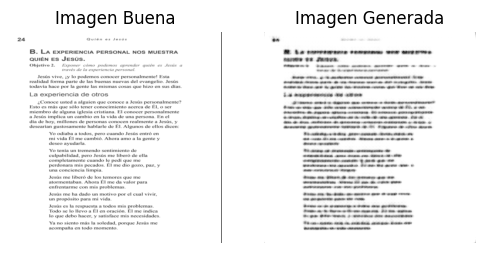

Epoch [11/160], Pérdida: 0.046631491540566734
Epoch [12/160], Pérdida: 0.045167661879373634
Epoch [13/160], Pérdida: 0.04284654792560184
Epoch [14/160], Pérdida: 0.043913246820802276
Epoch [15/160], Pérdida: 0.041627938251780426
Epoch [16/160], Pérdida: 0.03991699494097544
Epoch [17/160], Pérdida: 0.03782186908242495
Epoch [18/160], Pérdida: 0.036517161552024925
Epoch [19/160], Pérdida: 0.03488922143435996
Epoch [20/160], Pérdida: 0.03514775180298349
Modelo guardado en: /home/rodrigo/Documentos/5to semestre/machin/modelos/_epoch_20.pth


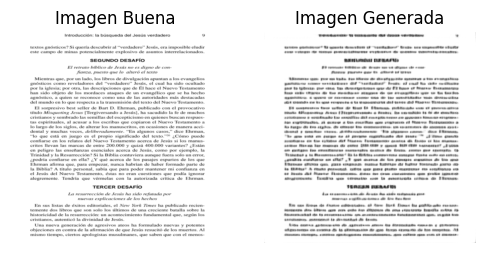

Epoch [21/160], Pérdida: 0.03335848539743735
Epoch [22/160], Pérdida: 0.03403563659800136
Epoch [23/160], Pérdida: 0.03427223059470239


In [15]:
# Hiperparametros
tam_batch = 32
tam_workers = 4
# Definición de los parámetros del entrenamiento
num_epochs = 160
visualization_interval = 10  # Visualizar cada 5 épocas, por ejemplo
dims = 500


# Definir transformaciones
transformacion = transforms.Compose([
    transforms.Resize((dims, dims)),  # Redimensionar a 500x500
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizar a un rango [-1, 1]
])

# Crear conjuntos de datos de entrenamiento y validación
conjunto_entrenamiento = ImageDataset(
    dir_buenas='BuenasTrain',
    dir_rayadas='RayadasTrain',
    transformacion=transformacion
)

conjunto_validacion = ImageDataset(
    dir_buenas='BuenasVal',
    dir_rayadas='RayadasVal',
    transformacion=transformacion
)

# Crear los cargadores de datos para entrenamiento y validación
cargador_entrenamiento = DataLoader(conjunto_entrenamiento, batch_size=tam_batch, shuffle=True, num_workers=tam_workers)
cargador_validacion = DataLoader(conjunto_validacion, batch_size=tam_batch, shuffle=False, num_workers=tam_workers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

modelo_generador = Generador().to(device)
modelo_generador_preentrenado = preentrenar_generador(device,modelo_generador, conjunto_entrenamiento, device, num_epochs=num_epochs, intervalo_visualizacion=visualization_interval)